In [1]:
from model import CVAE
import matplotlib.pyplot as plt
import numpy as np
device = 'mps'

## Analysis:

For the generative model we tried a variational autoencoder with linear layers, and a convolutional variational autoencoder. The convolutional VAE performed better which was expected as convolutional layers are better at capturing local patterns in image data.

The CVAE has 8 hidden layers, a latent space of 64 dimensions, and is trained based on MSE loss between the reconstructed image and the image at time t+1. This trains the model to predict images at t+1, when given an image at time t. We varied the dimension of the latent space and the number of hidden layers but this did not have a big effect on model performance.

There were 125 individual fires in the training data, each of 100 timesteps. This meant that for the last image in a given fire, the image at t+1 was the beginning of the next fire. 

To account for this we first tried to add a penalty to the loss function that penalised the model for predicting that the fire decreased in size between t and t+1. This improved MSE but the output images were noisy for small fires.

Instead, we created a custom dataset that paired up images in the training data within each individual fire (current image was paired with next image). The last image in each fire was paired with a replicate of itself. This worked well and produced the best predictions on the test data and model data.

## STEP 1

### Load and pre-process data

In [2]:
# Load data
train_data = CVAE.load_data('data/Ferguson_fire_train.npy')
test_data = CVAE.load_data('data/Ferguson_fire_test.npy')
satellite_data = CVAE.load_data('data/Ferguson_fire_obs.npy')
model_data = CVAE.load_data('data/Ferguson_fire_background.npy')

In [3]:
# Create datasets & dataloaders
train_dataset = CVAE.CustomDataset(train_data, batch_size=100, sequence_length=2)
model_dataset = CVAE.CustomDataset(model_data, batch_size=5, sequence_length=2)
train_loader = CVAE.make_dataloader(train_dataset, batch_size=64, shuffle=True)
test_dataset = CVAE.CustomDataset(test_data, batch_size=100, sequence_length=2)
test_loader = CVAE.make_dataloader(test_dataset, batch_size=64, shuffle=True)

### Either train the model or load pre-trained model

Uncomment the cell below if you want to train the model.

In [4]:
# # Train model 
# dims_latent = 64
# ModelClass = CVAE.VariationalAutoencoder(dims_latent)
# cvae_model, losses = CVAE.train(ModelClass, train_loader, device, epochs=10)
# CVAE.save_model(cvae_model, 'model_pth/cvae_trained_model_10_epochs.pth')

The cell below loads the trained model. The trained model can be downloaded from the onedrive link as instructed in the project README.

In [5]:
# Load model
dims_latent = 64
ModelClass = CVAE.VariationalAutoencoder(dims_latent)
cvae_model = CVAE.load_model('model_pth/cvae_trained_model_10_epochs.pth', ModelClass, device)

### Test the model on the test dataset

In [6]:
# Make predictions
test_predictions = CVAE.make_forecast(test_dataset, cvae_model)

In [7]:
# Calculate MSE
mse = CVAE.mse(test_data[1:], test_predictions[:-1])
print(f'Test data MSE: {mse}')

Test data MSE: 0.007306592738906299


Visualise test data results:

[1935 4459  844  988]


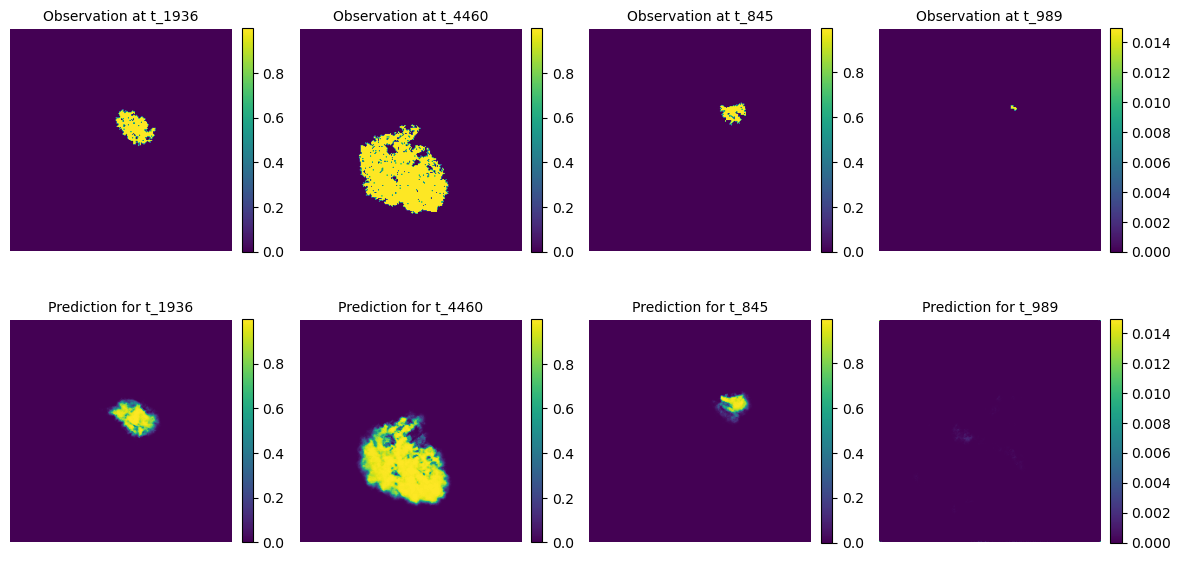

In [8]:
# Comparing predictions of t+1 with actual t+1 in test data
CVAE.visualise_results(4, test_predictions, test_data, seed=37)

## STEPS 2 & 3

Forecasting 4 timesteps for the background data and comparing this to the corresponding satellite data.

In [9]:
# Use the model data to make forecasts for 4 timesteps
predictions = CVAE.make_forecast(model_dataset, cvae_model)[:-1]
np.save('data/predictions_cvae.npy', predictions)
np.save('data/observations.npy', satellite_data)

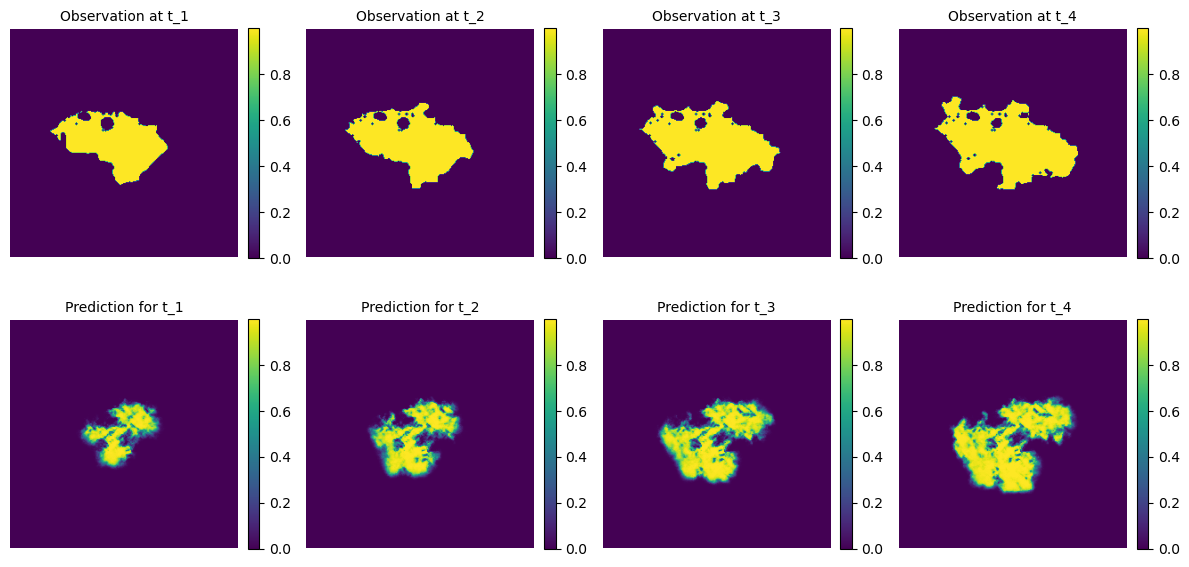

In [10]:
CVAE.visualise_results(4, predictions, satellite_data, ts=[0,1,2,3])

Calculate MSE between the satellite data and the predictions.

In [11]:
# MSE between forecasts and satellite data
print(f'MSE between forecast and satellite data: {CVAE.mse(satellite_data[1:], predictions)}')

MSE between forecast and satellite data: 0.0722131864891317


Assessing model quality by calculating average mse between the predictions for t+1 and the model background data at t+1.

In [12]:
# MSE between forecasts and model data
print(f'MSE between forecast and model data: {CVAE.mse(model_data[1:], predictions)}')

MSE between forecast and model data: 0.026993653368408175


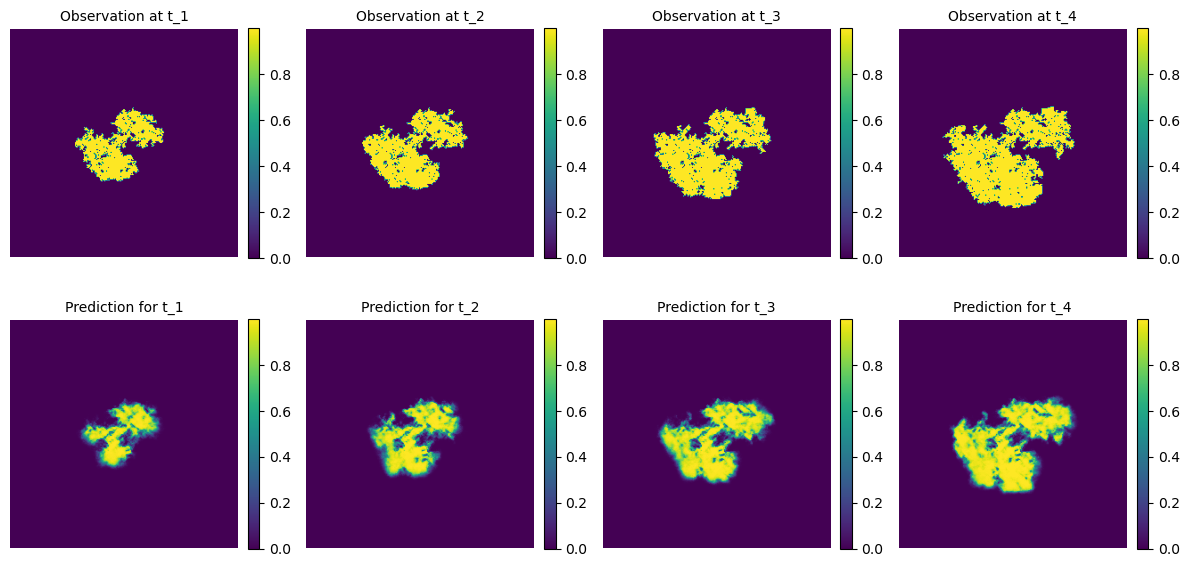

In [13]:
# Visualising difference between model data ("observation") and forecast
CVAE.visualise_results(4, predictions, model_data, ts=[0,1,2,3])